# Grad-cam

In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [2]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A

from torchvision import datasets, transforms
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.utils import class_weight
import seaborn as sns
sns.set(font_scale=1.2)

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, LayerCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

setting = 'photobox'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'

Available workers: 16


In [3]:
dfs = InsectImgDataset(ext=ext, setting=setting, directory=DATA_DIR)
df_train = pd.read_parquet(f"{SAVE_DIR}/df_train_{setting}.parquet")
df_val = pd.read_parquet(f"{SAVE_DIR}/df_val_{setting}.parquet")
df_test = pd.read_parquet(f"{SAVE_DIR}/df_test_{setting}.parquet")

topclasses = df_train['txt_label'].unique().tolist()

transforms_list_train = [
#     A.SmallestMaxSize(max_size=150),
#     A.Resize(height=150,width=150,p=1),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225], p=1, always_apply=True),
    A.ShiftScaleRotate(shift_limit=0.01,rotate_limit=45, scale_limit=0, p=.5),
    A.Rotate(limit=90, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # A.RandomGamma(p=0.5),
     A.RandomBrightnessContrast(p=0.2),
     A.GaussianBlur(blur_limit=(3,3), p=0.1)
]

transforms_list_test = [
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225], 
                p=1, 
                always_apply=True)
]

train_dataset = InsectImgDataset(df=df_train.reset_index(drop=True), transform=A.Compose(transforms_list_train))
valid_dataset = InsectImgDataset(df=df_val.reset_index(drop=True), transform=A.Compose(transforms_list_test))
test_dataset = InsectImgDataset(df=df_test.reset_index(drop=True), transform=A.Compose(transforms_list_test))

batch_size = 128
batch_size_val = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

torch.backends.cudnn.benchmark = True

In [4]:
modelname = "vgg16"
model = model_selector(modelname, pretrained=True)

if modelname.startswith("dense"):
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("resn"):
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("efficient"):
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("vgg"):
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, len(topclasses))
    
num_epochs = 40

class_sample_count = np.unique(df_train.label, return_counts=True)[1]
weight = 1. / class_sample_count  
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weight).cuda(), label_smoothing=.15)
optimizer = optim.Adam(model.parameters(), lr=.001)

model, optimizer = load_checkpoint(f'{SAVE_DIR}/{modelname}_{setting}_best.pth.tar', model, optimizer)

In [5]:
target_layers = [model.features[-1]]
# Construct the CAM object once, and then re-use it on many images:


In [6]:
labelticks = list({'bl':0,'wswl':1,'sp':2,'t':3,'sw':4,'k':5,'m':6,'c':7,'v':8,'wmv':9,'wrl':10}.keys())
labeldict = {'bl':0,'wswl':1,'sp':2,'t':3,'sw':4,'k':5,'m':6,'c':7,'v':8,'wmv':9,'wrl':10}
class_names = {str(v): [k,k] for k, v in labeldict.items()}
class_names

{'0': ['bl', 'bl'],
 '1': ['wswl', 'wswl'],
 '2': ['sp', 'sp'],
 '3': ['t', 't'],
 '4': ['sw', 'sw'],
 '5': ['k', 'k'],
 '6': ['m', 'm'],
 '7': ['c', 'c'],
 '8': ['v', 'v'],
 '9': ['wmv', 'wmv'],
 '10': ['wrl', 'wrl']}

In [7]:
test_bacc, test_cm, y_true, y_pred, info = test_model(model.cuda(),test_dataloader, test_dataset)
df_info = pd.DataFrame(info)
df_test["y_true"] = y_true
df_test["y_pred"] = y_pred

Testing..	: 100%|███████████████████████| 37/37 [00:13<00:00,  2.76it/s]


In [8]:
def plot_CAM(dataset, n, cam, df_test=df_test, save=True):
    index = dataset[n][1]
    label = class_names[str(index)][0]
    fname = dataset[n][4]
    pred = class_names[str(df_test.query(f'filename==\"{fname}\"').y_pred.values[0])][0]

    input_tensor = torch.as_tensor(dataset[n][0])
    rgb_img = torch.as_tensor(dataset[n][0]).permute(1,2,0).numpy()
    rgb_img = (rgb_img - np.min(rgb_img))/np.ptp(rgb_img)

    plt.figure(figsize=(14,8))

    plt.subplot(1,3,1)
    plt.imshow(rgb_img)
    plt.grid(False)
    plt.axis('off')

    plt.title(f"true:{label}, pred:{pred}");

    plt.subplot(1,3,2)
    # for i, target_category in enumerate(class_names.keys()):
    #     plt.subplot(3,4,i+1)
    grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0), 
                        target_category=np.array([index]), 
                        aug_smooth=False, 
                        eigen_smooth=False)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    plt.imshow(visualization)
    # plt.title(label);
    plt.grid(False)
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(grayscale_cam);
    plt.grid(False)
    plt.axis('off')
    if save:
        plt.savefig(f"/home/kalfasyan/Dropbox/worklaptop_results/gradcam_{n}_{modelname}_{setting}.png", format='png', bbox_inches='tight')

In [9]:
test_dataset_range = range(3873,3884)

In [10]:
# test_dataset_range = range(7673,7684)

# GradCAM++

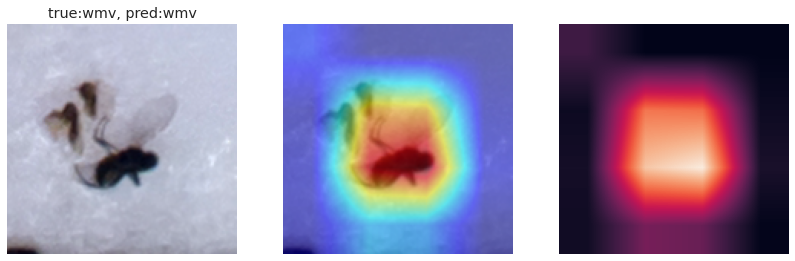

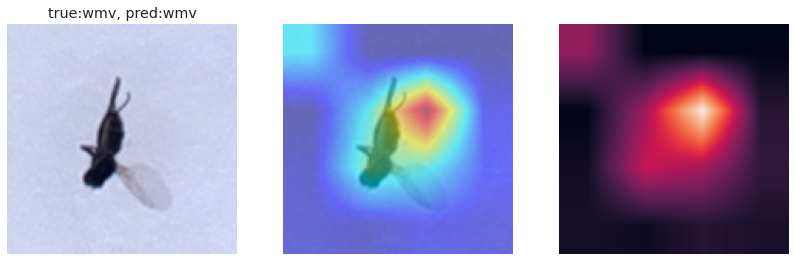

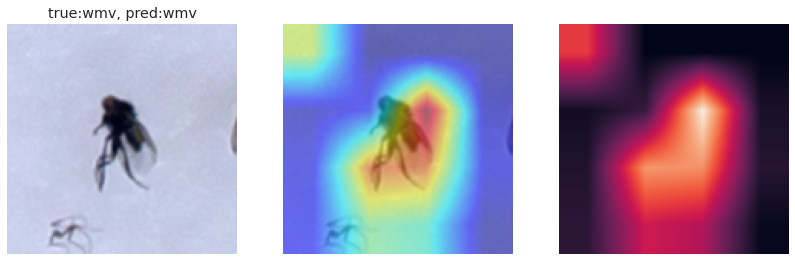

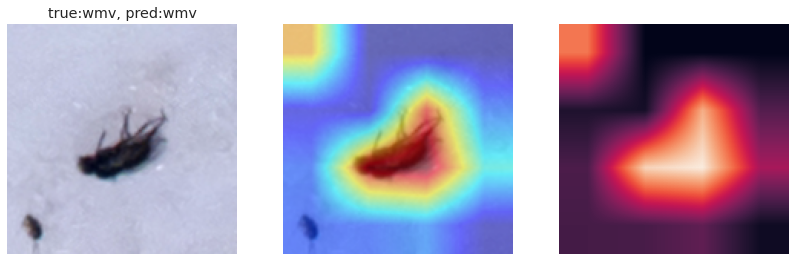

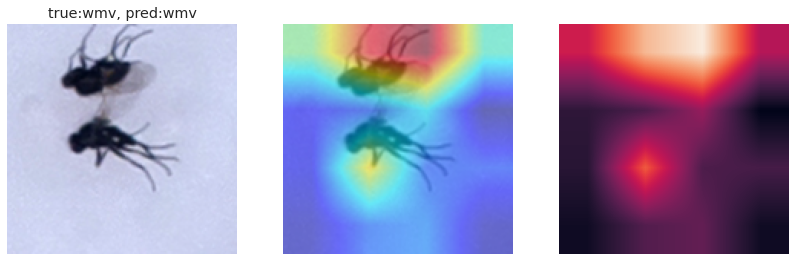

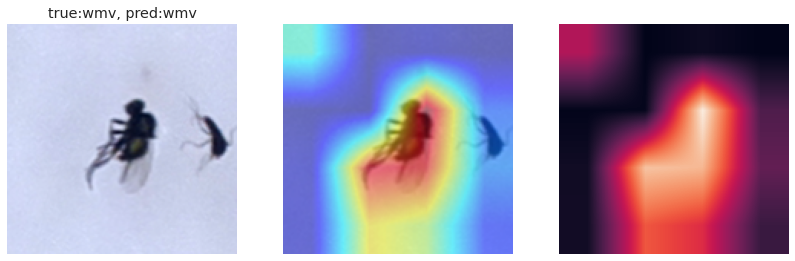

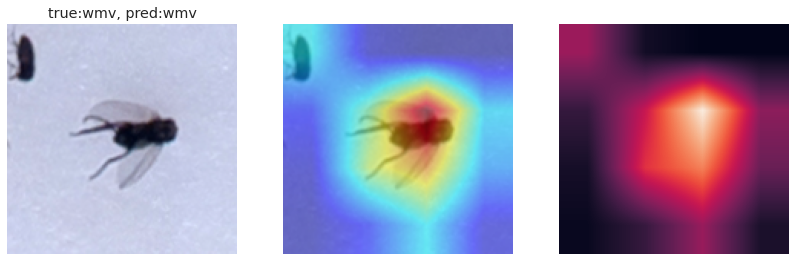

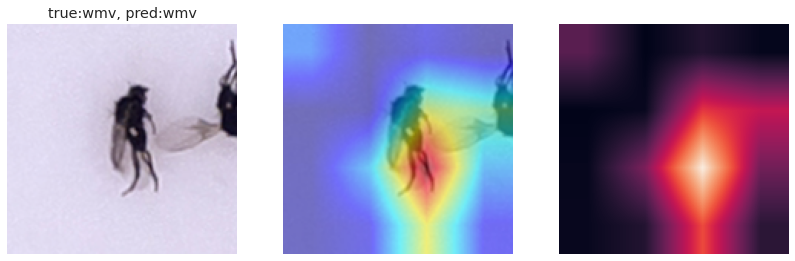

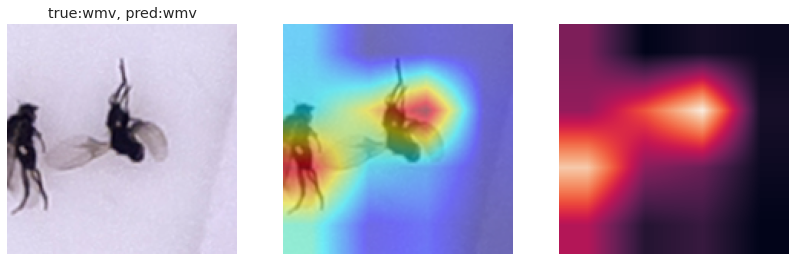

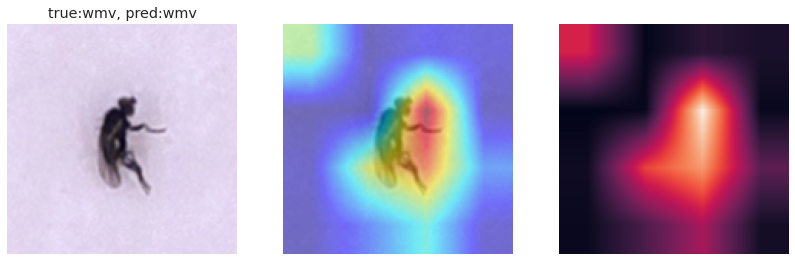

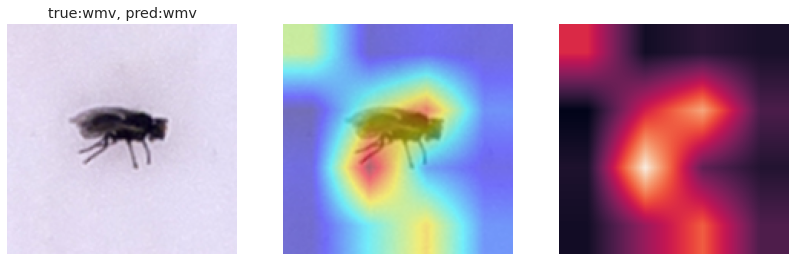

In [11]:
cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)
for i in test_dataset_range:
    plot_CAM(test_dataset, i, cam, save=True)

# XGradCAM

In [12]:
# cam = XGradCAM(model=model, target_layers=target_layers, use_cuda=True)
# for i in test_dataset_range:
#     plot_CAM(test_dataset, i, cam)

# EigenCAM

In [13]:
# cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=True)
# for i in test_dataset_range:
#     plot_CAM(test_dataset, i, cam)

# AblationCAM

In [14]:
# cam = AblationCAM(model=model, target_layers=target_layers, use_cuda=True)
# for i in test_dataset_range:
#     plot_CAM(test_dataset, i, cam)

# ScoreCAM

In [15]:
# cam = ScoreCAM(model=model, target_layers=target_layers, use_cuda=True)
# for i in test_dataset_range:
#     plot_CAM(test_dataset, i, cam)